### <span style="color:red">CONFIGURACIÓN: EJECUTAR UNA SOLA VEZ CUANDO SE INICIA EL COLAB.</span>

In [ ]:
!git clone https://github.com/mayala-afi/econometria-mf.git

%cd econometria-mf

!pip install -q -r requirements.txt

## SESION 3 : MODELOS VAR/VEC

#### Importación de librerías

In [1]:
import pandas as pd
import numpy as np

from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA


from utils import clean_fred_df, adf_test, irf_plot, plot_forecast, plot_acf_pacf, predict_plot_multi

import warnings

warnings.filterwarnings("ignore")

### 1. Importar datos desde Excel descargado de FRED

In [2]:
cpi_df = pd.read_excel("./data/CPIAUCSL.xlsx", sheet_name="Monthly")
ff_df = pd.read_excel("./data/FEDFUNDS.xlsx", sheet_name="Monthly")
pib_df = pd.read_excel("./data/GDPC1.xlsx", sheet_name="Quarterly")

### 2. Limpieza y preparación de datos

#### CPI (mensual --> trimestral promedio) 

In [3]:
cpi_df = clean_fred_df(cpi_df, "CPIAUCSL", "cpi")
cpi_q = (
    cpi_df["cpi"].to_period("M").to_timestamp().resample("Q").mean().to_period("Q")
)

#### FEDFUNDS (mensual --> trimestral promedio) 

In [4]:
ff_df = clean_fred_df(ff_df, "FEDFUNDS", "ff")
ff_q = ff_df["ff"].to_period("M").to_timestamp().resample("Q").mean().to_period("Q")

#### PIB (ya trimestral)

In [5]:
gdp_df = clean_fred_df(pib_df, "GDPC1", "pib")
gdp_q = gdp_df["pib"].to_period("Q")

#### Combinación de las series en un solo DataFrame

In [6]:
df = pd.concat([gdp_q, cpi_q, ff_q], axis=1)

df = df.loc["1988-10-01":]
display(df.head())

,pib,cpi,ff
fecha,,,
1988Q4,9673.405,120.300000,8.470000
1989Q1,9771.725,121.666667,9.443333
1989Q2,9846.293,123.633333,9.726667
1989Q3,9919.228,124.600000,9.083333
1989Q4,9938.767,125.866667,8.613333


### 3. Transformaciones

In [7]:
df["lnpib"] = np.log(df["pib"])
df["lninflacion"] = np.log(df["cpi"])
df["inflacion"] = 100 * df["lninflacion"].diff()
df["tipo_interes"] = df["ff"]

df["dlnpib"] = df["lnpib"].diff()
df["dinflacion"] = df["inflacion"].diff()
df["dtipo_interes"] = df["tipo_interes"].diff()

df = df.dropna()

### 4. Pruebas ADF - raíz unitaria

In [8]:
adf_test(df["lnpib"], "lnpib")
adf_test(df["inflacion"], "inflacion")
adf_test(df["tipo_interes"], "tipo_interes")

adf_test(df["dlnpib"], "dlnpib")
adf_test(df["dinflacion"], "dinflacion")
adf_test(df["dtipo_interes"], "dtipo_interes")

lnpib:
 -ADF=-0.894
 -p-value=0.790

inflacion:
 -ADF=-7.846
 -p-value=0.000

tipo_interes:
 -ADF=-2.977
 -p-value=0.037

dlnpib:
 -ADF=-13.649
 -p-value=0.000

dinflacion:
 -ADF=-9.687
 -p-value=0.000

dtipo_interes:
 -ADF=-4.607
 -p-value=0.000



### 5. Selección de retardos y VAR

In [9]:
var_data = df[["dlnpib", "inflacion", "dtipo_interes"]]
model = VAR(var_data)

model.select_order(maxlags=4)

In [10]:
var_res = model.fit(1)
print(var_res.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 23, Dec, 2025
Time:                     13:06:40
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -12.6551
Nobs:                     144.000    HQIC:                  -12.8020
Log likelihood:           328.004    FPE:                2.49174e-06
AIC:                     -12.9026    Det(Omega_mle):     2.29512e-06
--------------------------------------------------------------------
Results for equation dlnpib
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                    0.008350         0.001515            5.512           0.000
L1.dlnpib               -0.147048         0.090109           -1.632           0.103
L1.inflacion            -0.001832         0.001

### 6. Causalidad de Granger

In [11]:
var_res.test_causality("dlnpib", ["inflacion"], kind="f").summary()


Test statistic,Critical value,p-value,df
1.076,3.864,0.300,"(1, 420)"


### 7. Funciones Impulso-Respuesta

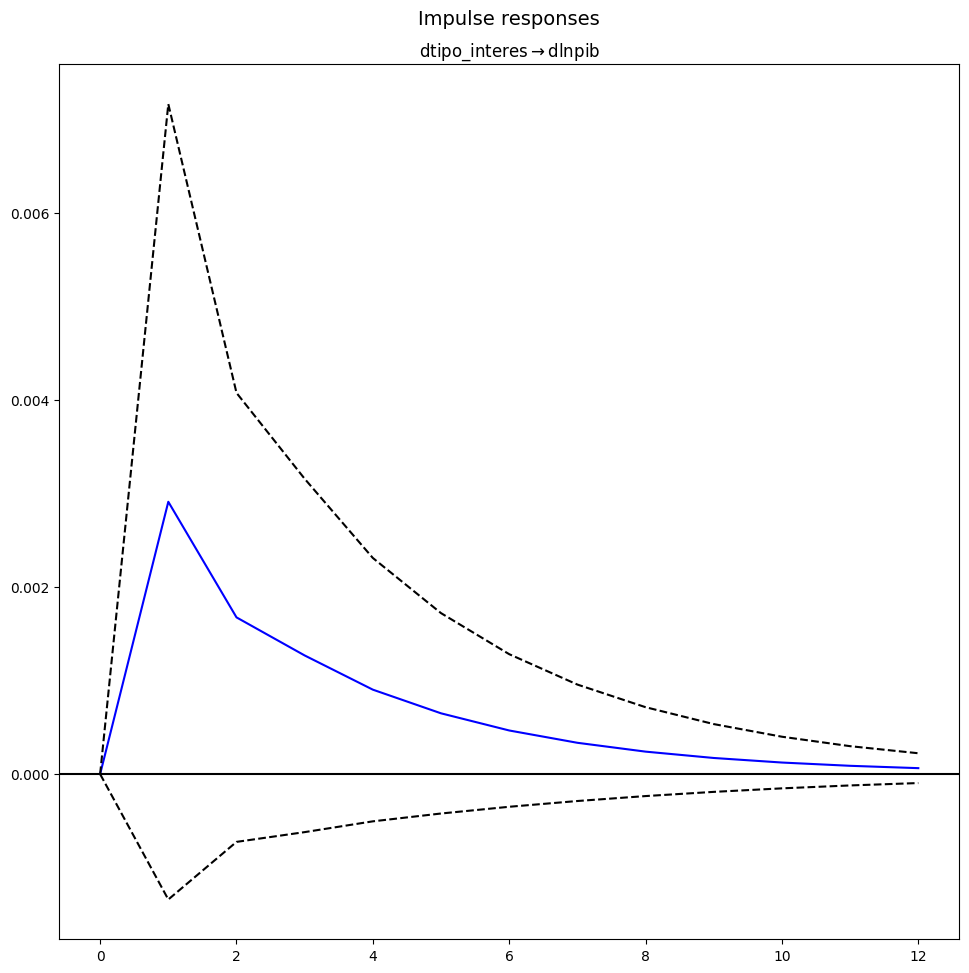

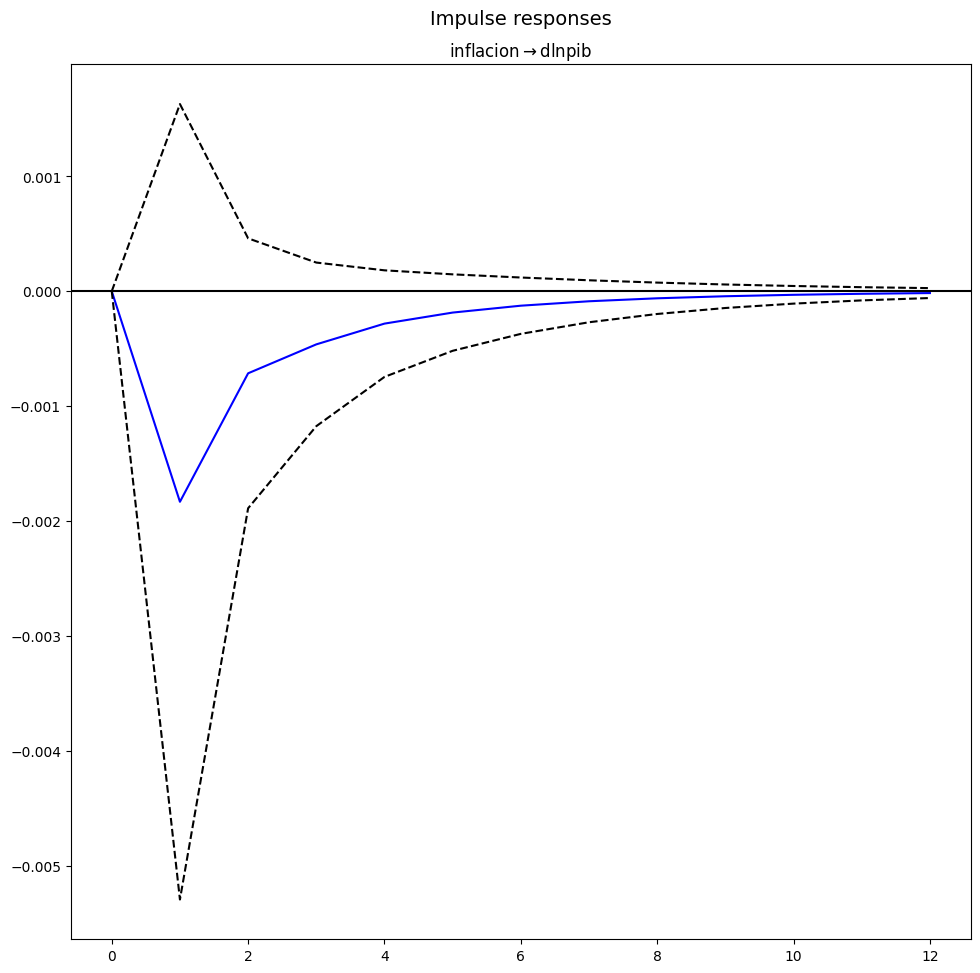

In [12]:
irf = var_res.irf(12)

irf_plot(impulse="dtipo_interes", response="dlnpib", irf=irf)
irf_plot(impulse="inflacion", response="dlnpib", irf=irf)


### 8. Cointegración (Johansen)

In [13]:
coint = coint_johansen(df[["lnpib", "inflacion", "tipo_interes"]], det_order=0, k_ar_diff=2)

coint.lr1  # estadísticos traza
coint.cvt  # valores críticos

array([[27.0669, 29.7961, 35.4628],
       [13.4294, 15.4943, 19.9349],
       [ 2.7055,  3.8415,  6.6349]])

_Si hay cointegración, entonces estimar un modelo VECM_

In [14]:
vecm = VECM(df[["lnpib", "inflacion", "tipo_interes"]], k_ar_diff=2, coint_rank=1)

vecm_res = vecm.fit()
print(vecm_res.summary())


Det. terms outside the coint. relation & lagged endog. parameters for equation lnpib
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
L1.lnpib           -0.1553      0.096     -1.609      0.108      -0.344       0.034
L1.inflacion        0.0010      0.002      0.538      0.590      -0.003       0.005
L1.tipo_interes     0.0002      0.003      0.076      0.940      -0.006       0.007
L2.lnpib           -0.0637      0.094     -0.675      0.499      -0.249       0.121
L2.inflacion        0.0001      0.002      0.075      0.940      -0.003       0.004
L2.tipo_interes     0.0035      0.003      1.107      0.268      -0.003       0.010
Det. terms outside the coint. relation & lagged endog. parameters for equation inflacion
                      coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------

### 9. Previsiones VEC

In [15]:
forecast = vecm_res.predict(steps=8)

_Dataframe para graficar_

In [16]:
h = 8 
last_period = df.index[-1]
future_index = pd.period_range(start=last_period + 1, periods=h, freq="Q")
df_forecast = pd.DataFrame(
    forecast, index=future_index, columns=["lnpib", "inflacion", "tipo_interes"]
)

ln(PIB)

Gráficos de previsiones VEC:
PIB


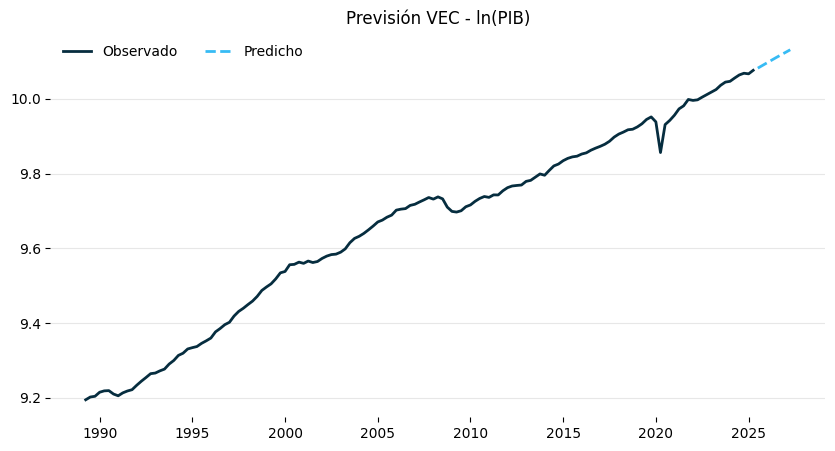

Inflación


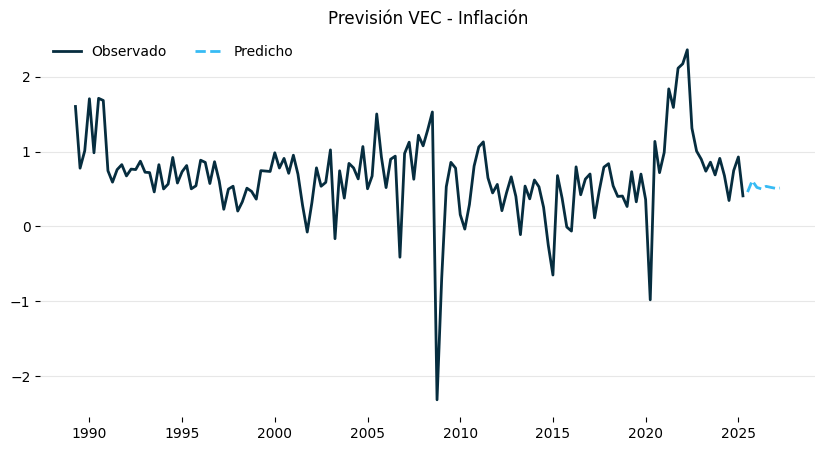

Tipo de interés


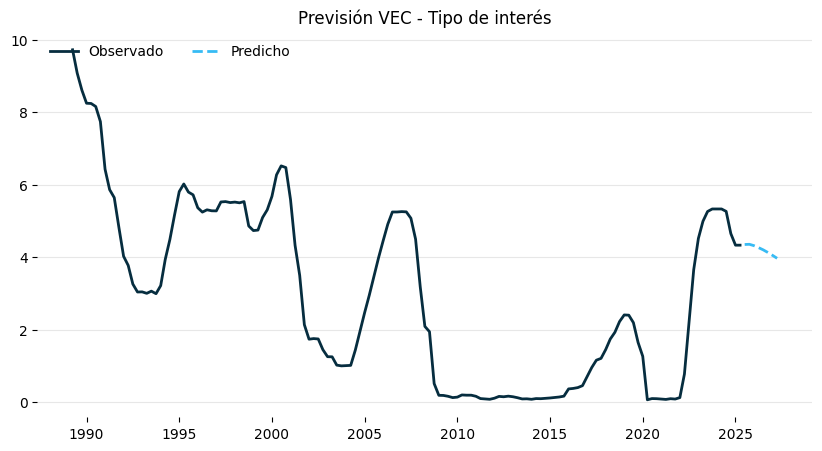

In [17]:
print("Gráficos de previsiones VEC:")
print("PIB")
plot_forecast(df, df_forecast, "lnpib", "Previsión VEC - ln(PIB)")
print("Inflación")
plot_forecast(df, df_forecast, "inflacion", "Previsión VEC - Inflación")
print("Tipo de interés")
plot_forecast(df, df_forecast, "tipo_interes", "Previsión VEC - Tipo de interés")


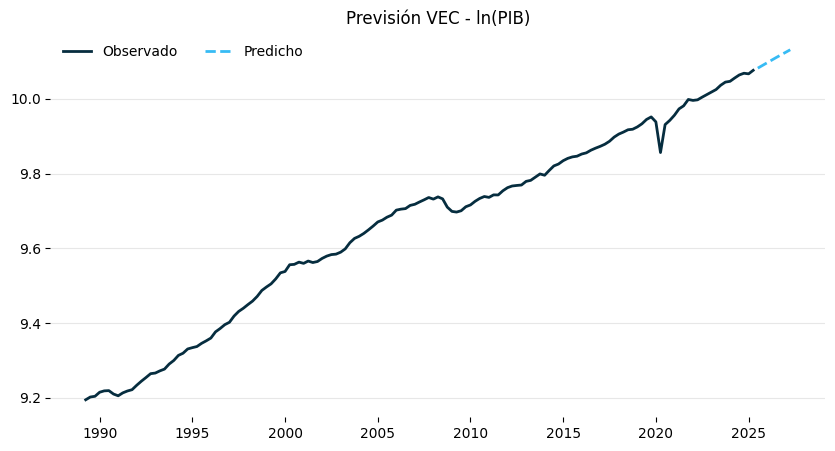

In [18]:
plot_forecast(df, df_forecast, "lnpib", "Previsión VEC - ln(PIB)")

### 10. Comparación del PIB: MCO vs VEC vs ARIMA

#### MCO: Regresión contemporánea (SESIÓN 1)

In [19]:
Y = df["dlnpib"]
X = sm.add_constant(df[["inflacion", "dtipo_interes"]])

ols = sm.OLS(Y, X).fit()
df["yhat_mco"] = ols.fittedvalues

#### ARIMA Univariante (SESIÓN 2)

_Visualizar ACF y PACF para identificar órdenes_

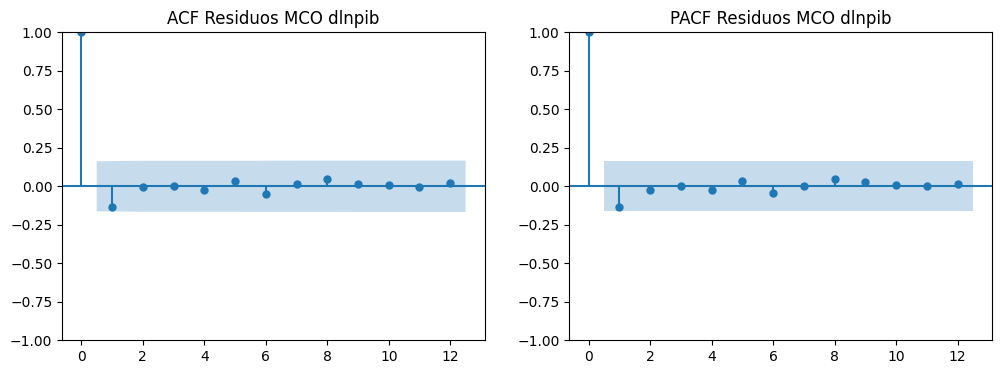

In [20]:
plot_acf_pacf(df, var="dlnpib", lags=12, title_suffix="Residuos MCO dlnpib")

In [21]:
arima = ARIMA(df["dlnpib"], order=(1, 0, 1)).fit()
df["yhat_arima"] = arima.fittedvalues


#### VEC (SESIÓN 3)

In [22]:
fitted = vecm_res.fittedvalues

fitted_df = pd.DataFrame(
    fitted, index=df.index[-fitted.shape[0] :], columns=["lnpib", "inflacion", "tasa"]
)

df["yhat_vec_lnpib"] = fitted_df["lnpib"]

df["yhat_vec"] = fitted_df["lnpib"].diff()


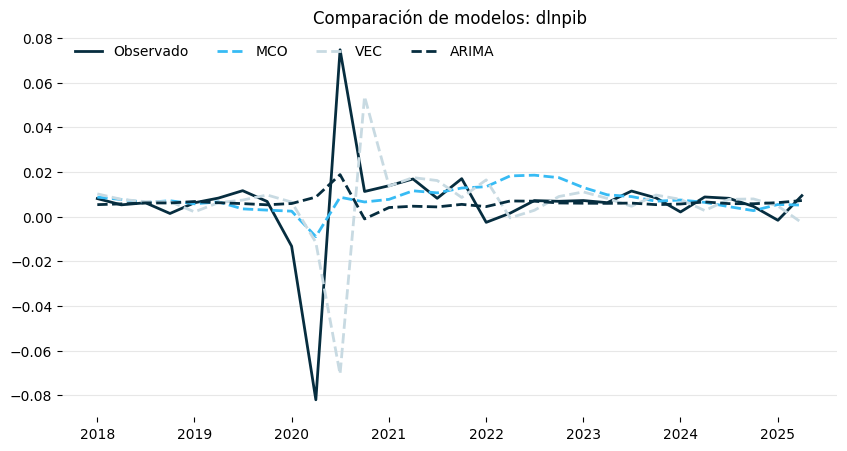

In [23]:
df_plot = df.loc["2018-01-01":, ["dlnpib", "yhat_mco", "yhat_vec", "yhat_arima"]]

predict_plot_multi(
    df_plot,
    title="Comparación de modelos: dlnpib",
    labels=["Observado", "MCO", "VEC", "ARIMA"],
)

### 11. Errores cuadráticos

In [24]:
df["error2_mco"] = (df["dlnpib"] - df["yhat_mco"]) ** 2
df["error2_vec"] = (df["dlnpib"] - df["yhat_vec"]) ** 2
df["error2_arima"] = (df["dlnpib"] - df["yhat_arima"]) ** 2

df[["error2_mco", "error2_vec", "error2_arima"]].mean()

error2_mco      0.000102
error2_vec      0.000239
error2_arima    0.000118
dtype: float64